In [1]:
# Necessary imports
import os
import csv
import math
import random as rnd
import operator
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import time
np.random.seed(123)


In [2]:
# Paths for the data files - This work assumes that the data files are in the local directory with the file
# Can change the directories to access to the files
training_data_paths = ["question-3-train-protein-index.csv", "question-3-train-features.csv", "question-3-train-labels.csv"]
validate_data_paths = ["question-3-valid-protein-index.csv", "question-3-valid-features.csv", "question-3-valid-labels.csv"]
index_path = 'question-3-drug-index.csv'
training_labels = pd.read_csv(training_data_paths[2], header = None).to_numpy()
training_features = pd.read_csv(training_data_paths[1], header = None).to_numpy()
valid_labels = pd.read_csv(validate_data_paths[2], header = None).to_numpy()
valid_features = pd.read_csv(validate_data_paths[1], header = None).to_numpy()

In [3]:
# Euclidean Distance between two data points
def euclidean_distance(data_1, data_2):
    assert data_1.size == data_2.size
    distance = np.subtract(data_1, data_2)
    distance = np.sqrt(np.power(distance, 2))
    return np.sum(distance)

In [4]:
# Manhattan Distance between two data points
def manhattan_distance(row_1, row_2):
    assert row_1.size == row_2.size
    difference = np.subtract(row_1, row_2)
    difference = np.absolute(difference)
    return np.sum(difference)

In [5]:
start = time.time()
dist = euclidean_distance(valid_features[0], training_features[0])
print('Euclidean distance: ' + str(dist))
end = time.time()
euc_unit_time = end - start
print('Time for computing euclidean distance of two instances: ' + str(end - start))
start = time.time()
dist = manhattan_distance(valid_features[0], training_features[0])
print('Manhattan distance: ' + str(dist))
end = time.time()
print('Time for computing manhattan distance of two instances: ' + str(end - start))
man_unit_time = end - start
if euc_unit_time < man_unit_time:
    print('Computing Euclidean distance is faster by a factor of: ' + str(man_unit_time / euc_unit_time))
else:
    print('Computing Manhattan distance is faster by a factor of: ' + str(euc_unit_time / man_unit_time))

Euclidean distance: 5.0
Time for computing euclidean distance of two instances: 0.0029730796813964844
Manhattan distance: 5
Time for computing manhattan distance of two instances: 0.0006110668182373047
Computing Manhattan distance is faster by a factor of: 4.865392118611003


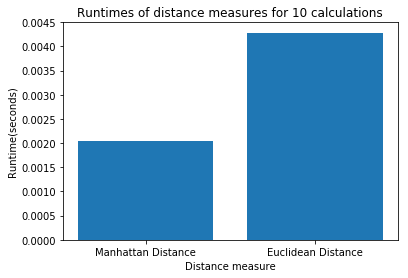

In [6]:
# Analysis of runtimes two distance measures for 5 measurements
start_1 = time.time()
for i in range(10):
    euclidean_distance(valid_features[0], training_features[0])
end_1 = time.time()
start_2 = time.time()
for i in range(10):
    manhattan_distance(valid_features[0], training_features[0])
end_2 = time.time()
plt.bar(['Manhattan Distance', 'Euclidean Distance'], [end_2 - start_2, end_1 - start_1])
plt.xlabel('Distance measure')
plt.ylabel('Runtime(seconds)')
plt.title('Runtimes of distance measures for 10 calculations')
plt.show()

In [7]:
# Compute distances for one validation data
def compute_distances(valid_row, training_data, training_labels):
    distances = []
    for sample_idx in range(training_data.shape[0]):
        distances.append((manhattan_distance(valid_row, training_data[sample_idx]), training_labels[sample_idx][0]))
    return distances

In [8]:
# Get the kth nearest neighbors of the sample data
def get_k_neighbors(training_data, training_labels, test_row, k):
    distances = compute_distances(test_row, training_data, training_labels)
    neighbors = distances = sorted(distances, key=operator.itemgetter(0))
    return neighbors[0:k]

In [9]:
def evaluate_KNN_value(training_data, training_labels, test_data_sample, k):
    k_neighbors = get_k_neighbors(training_features, training_labels, test_data_sample, k)
    positive_labels = 0
    negative_labels = 0
    for n in range(k):
        if k_neighbors[n][1] == 0:
            negative_labels += 1
        else:
            positive_labels += 1
    if positive_labels > negative_labels:
        return 1
    return 0

In [21]:
def evaluate_classifier(training_data, training_labels, test_data, test_labels, k):
    true_count = 0
    predicted_positive = 0
    predicted_negative = 0
    positives = [0,0] # first index is the number or false positives, second is true posivites
    negatives = [0,0] # first index is the number of false negatives, second is true negatives
    for idx in range(test_data.shape[0]):
        val = evaluate_KNN_value(training_data, training_labels, test_data[idx], k)
        if val == test_labels[idx]:
            true_count += 1
            if val == 1:
                positives[1] += 1
                predicted_positive += 1
            else:
                negatives[1] += 1
                predicted_negative += 1
        else:
            if val == 1:
                positives[0] += 1
                predicted_positive += 1
            else:
                negatives[0] += 1
                predicted_negative += 1
    result = ((true_count / (test_labels.size)), (predicted_positive, predicted_negative), (positives, negatives))
    return result

In [25]:
def evaluate_for_all_k(training_data, training_labels, test_data, test_labels):
    k_set = (1,3,5,10,20,50,100,200)
    accuracy = []
    times = []
    precision = []
    results = []
    for i in range(len(k_set)):
        start = time.time()
        val = (evaluate_classifier(training_data, training_labels, test_data, test_labels, k_set[i]))
        print(val)
        end = time.time()
        times.append(end - start)
        print('K: ' + str(k_set[i]))
        if val[1][0] == 0:
            print('Accuracy: ' + str(val[0]) + ', Precision : ' + str(0))
            precision.append(0)
        else:
            print('Accuracy: ' + str(val[0]) + ', Precision : ' + str(val[2][0][1] / val[1][0]))
            precision.append(val[2][0][1] / val[1][0])
        print('Runtime: ' + str(end - start))
        accuracy.append(val[0])
    results.append(accuracy)
    results.append(precision)
    results.append(times)
    return results
print('The accuracy and runtime results for different k values: ')
test_results = evaluate_for_all_k(training_features, training_labels, valid_features, valid_labels)

The accuracy and runtime results for different k values: 
(0.7838405036726128, (297, 656), ([156, 141], [50, 606]))
K: 1
Accuracy: 0.7838405036726128, Precision : 0.47474747474747475
Runtime: 560.7839426994324
(0.8835257082896117, (98, 855), ([9, 89], [102, 753]))
K: 3
Accuracy: 0.8835257082896117, Precision : 0.9081632653061225
Runtime: 540.6097581386566
(0.8646379853095488, (66, 887), ([2, 64], [127, 760]))
K: 5
Accuracy: 0.8646379853095488, Precision : 0.9696969696969697
Runtime: 565.0499711036682
(0.8310598111227702, (34, 919), ([2, 32], [159, 760]))
K: 10
Accuracy: 0.8310598111227702, Precision : 0.9411764705882353
Runtime: 552.7982199192047
(0.8216159496327388, (21, 932), ([0, 21], [170, 762]))
K: 20
Accuracy: 0.8216159496327388, Precision : 1.0
Runtime: 589.2516300678253
(0.7995802728226653, (0, 953), ([0, 0], [191, 762]))
K: 50
Accuracy: 0.7995802728226653, Precision : 0
Runtime: 591.7741060256958
(0.7995802728226653, (0, 953), ([0, 0], [191, 762]))
K: 100
Accuracy: 0.799580272

In [ ]:
def main():
    # Data imports done when you run the script from the beginning
    test_results = evaluate_for_all_k(training_features, training_labels, valid_features, valid_labels) # Executes the kNN classifier for all k values.
    print(test_results)
main()

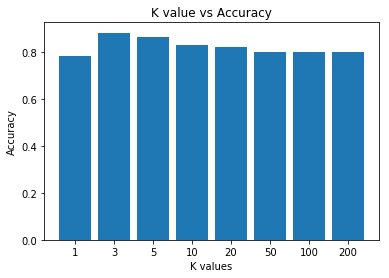

In [26]:
# Plotting k value versus accuracy
accuracies = test_results[0]
k_values = ['1','3','5','10','20','50','100','200']
plt.bar(k_values, accuracies)
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.title('K value vs Accuracy')
plt.show()

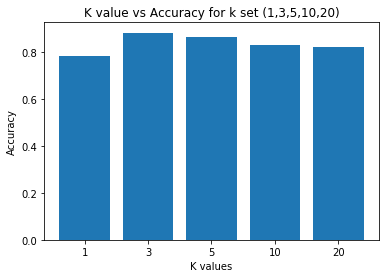

In [27]:
# For a closer view
plt.bar(k_values[0:5], accuracies[0:5])
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.title('K value vs Accuracy for k set (1,3,5,10,20)')
plt.show()

In [28]:
# K value and accuracy table for a final view
acc_vs_k = pd.DataFrame({'K value': k_values, 'Accuracy': accuracies})
acc_vs_k

,K value,Accuracy
0,1,0.783841
1,3,0.883526
2,5,0.864638
3,10,0.831060
4,20,0.821616
5,50,0.799580
6,100,0.799580
7,200,0.799580


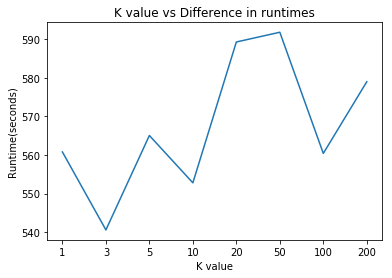

In [29]:
# Plotting k value versus runtime
runtimes = test_results[2]
plt.plot(k_values, runtimes)
plt.xlabel('K value')
plt.ylabel('Runtime(seconds)')
plt.title('K value vs Difference in runtimes')
plt.show()

In [30]:
# Plotting k values and runtime values as a final insight
time_vs_k = pd.DataFrame({'K values': k_values, 'Runtime(seconds)': runtimes})
time_vs_k

,K values,Runtime(seconds)
0,1,560.783943
1,3,540.609758
2,5,565.049971
3,10,552.798220
4,20,589.251630
5,50,591.774106
6,100,560.413111
7,200,578.966843


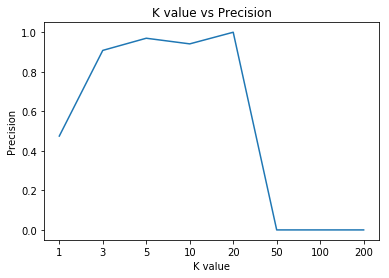

In [31]:
# Plotting k value versus precision
precision = test_results[1]
plt.plot(k_values, precision)
plt.xlabel('K value')
plt.ylabel('Precision')
plt.title('K value vs Precision')
plt.show()

In [32]:
precision_vs_k = pd.DataFrame({'K values' : k_values, 'Precision' : precision})
precision_vs_k

,K values,Precision
0,1,0.474747
1,3,0.908163
2,5,0.969697
3,10,0.941176
4,20,1.000000
5,50,0.000000
6,100,0.000000
7,200,0.000000
